# Covid-19 forecasting 

## Введение. Постановка целей и задач.

Цель: проведение исследования данных и построение прогноза развития пандемии COVID19 в Афганистане.

Задачи:

провести анализ данных о распространении COVID19 в Афганистане;
выявить взаимосвязи между ключевыми событиями в данных в Афганистане;
построить прогноз распространения пандемии COVID19 в Афганистане.
Используя три модели прогнозирования будующего узнать о течение болезни в Афганистане.

## Импорт библиотек, ознакомление с данными.

### Импорт Датафрейма, библиотек, написание функций.

In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 7.8 MB/s 
     |████████████████████████████████| 9.8 MB 25.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
!pip install fbprophet

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [4]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [5]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


### Знакомство с данными.

Задачи:
1. Изучить данные визуально.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149711 entries, 0 to 149710
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149711 non-null  object 
 1   continent                                   140678 non-null  object 
 2   location                                    149711 non-null  object 
 3   date                                        149711 non-null  object 
 4   total_cases                                 147102 non-null  float64
 5   new_cases                                   147076 non-null  float64
 6   new_cases_smoothed                          145951 non-null  float64
 7   total_deaths                                130056 non-null  float64
 8   new_deaths                                  130228 non-null  float64
 9   new_deaths_smoothed                         145951 non-null  float64
 

In [7]:
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [100]:
len(df.location)

149711

Вывод: Мы имеем дело с большим количеством данных. Данные взяты с интернет ресурса и представляют собой информацию о заболевании Covid-19  в различных странах.

## Предобработка данных

Задачи:
1. Сделать фильтрацию по нужным данным;
2. Определить и устранить пропуски в данных;
3. Определелить и изменить тип данных, при необходимости.

In [8]:
df_new = df[df.location == 'Afghanistan'][['location', 'date', 'new_deaths', 'new_cases', 'total_cases', 'total_deaths']]

In [9]:
df_new.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
0,Afghanistan,2020-02-24,NaN,5.0,5.0,NaN
1,Afghanistan,2020-02-25,NaN,0.0,5.0,NaN
2,Afghanistan,2020-02-26,NaN,0.0,5.0,NaN
3,Afghanistan,2020-02-27,NaN,0.0,5.0,NaN
4,Afghanistan,2020-02-28,NaN,0.0,5.0,NaN


In [10]:
# Наблюдаем в данных пропуски (NaN)

In [11]:
df_new.isna()
# Для определения NaN значений пользуемся функцией isna. В результате видим, что пропуски действительно есть (True).

,location,date,new_deaths,new_cases,total_cases,total_deaths
0,False,False,True,False,False,True
1,False,False,True,False,False,True
2,False,False,True,False,False,True
3,False,False,True,False,False,True
4,False,False,True,False,False,True
...,...,...,...,...,...,...
665,False,False,False,False,False,False
666,False,False,False,False,False,False
667,False,False,False,False,False,False
668,False,False,False,False,False,False


In [14]:
# проверим, в каждой ли колонке есть пропуски
df_check_nan = df_new.isna()

In [15]:
df_check_nan.columns
# выводим название колонок

Index(['location', 'date', 'new_deaths', 'new_cases', 'total_cases',
       'total_deaths'],
      dtype='object')

In [16]:
for i in df_check_nan.columns:
    print(f'Для признака {i} пропуски: ', df_check_nan[i].unique())
# используя цикл, проходимся по всем колонкам, смотрим в каких колонках есть пропуски

Для признака location пропуски:  [False]
Для признака date пропуски:  [False]
Для признака new_deaths пропуски:  [ True False]
Для признака new_cases пропуски:  [False]
Для признака total_cases пропуски:  [False]
Для признака total_deaths пропуски:  [ True False]


In [17]:
df_new = df_new.fillna(0)
# используя функцию fillna, заменяем пропуски на 0

In [18]:
df_new.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
0,Afghanistan,2020-02-24,0.0,5.0,5.0,0.0
1,Afghanistan,2020-02-25,0.0,0.0,5.0,0.0
2,Afghanistan,2020-02-26,0.0,0.0,5.0,0.0
3,Afghanistan,2020-02-27,0.0,0.0,5.0,0.0
4,Afghanistan,2020-02-28,0.0,0.0,5.0,0.0


In [19]:
df_new.dtypes
# Проверяем типы данных

location         object
date             object
new_deaths      float64
new_cases       float64
total_cases     float64
total_deaths    float64
dtype: object

In [20]:
df_new['location'] = df_new['location'].astype('string')
df_new['date'] = pd.to_datetime(df_new['date'])

In [21]:
df_new.dtypes
# заменили типы данных, смотрим результат

location                string
date            datetime64[ns]
new_deaths             float64
new_cases              float64
total_cases            float64
total_deaths           float64
dtype: object

Вывод: Сделали фильтрацию из основных данных по колонке Afghanistan. Выбрали из данных колонки date	new_deaths	new_cases	total_cases	total_deaths, необходимые для проведения статистического анализа. Предобработка данных показала, что в данных присутствуют пробелы, типы данных колонок location и date определяются как объект. Для кооректного считывания данных было необходимо убрать пробелы и изменить тип данных колонок location и date.
В результате предобработки пустые значения заменены на значение = 0, тип данных колонок location и date перезаписаны в эти же колонки,только с типом данных string и datetime64[ns].

## EDA или разведочный анализ данных.

Задачи:
1. Сделать индекс к колонке date
2. Вывести статистику по нужным столбцам;
3. Построить графическое отображение столбцов;
4. Выявить связи между признаками (почему заболеваемость может расти или падать и тп)

In [22]:
df_new.index = df_new.date
#Делаем индекс к колонке date

In [23]:
# Входная выборка для анализа
df_new.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2020-02-24,Afghanistan,2020-02-24,0.0,5.0,5.0,0.0
2020-02-25,Afghanistan,2020-02-25,0.0,0.0,5.0,0.0
2020-02-26,Afghanistan,2020-02-26,0.0,0.0,5.0,0.0
2020-02-27,Afghanistan,2020-02-27,0.0,0.0,5.0,0.0
2020-02-28,Afghanistan,2020-02-28,0.0,0.0,5.0,0.0


In [24]:
# Проведем расчет основных статистических метрик
df_new.describe()

,new_deaths,new_cases,total_cases,total_deaths
count,670.000000,670.000000,670.000000,670.000000
mean,10.967164,235.652239,70021.108955,3020.783582
std,19.341757,405.646186,53543.712662,2563.014755
min,0.000000,-2.000000,5.000000,0.000000
25%,1.000000,25.000000,37140.000000,1316.000000
50%,4.000000,75.500000,54577.000000,2375.500000
75%,11.000000,225.750000,132479.250000,5618.750000
max,159.000000,3243.000000,157887.000000,7348.000000


#колонка минум выдала отрицательное значение!

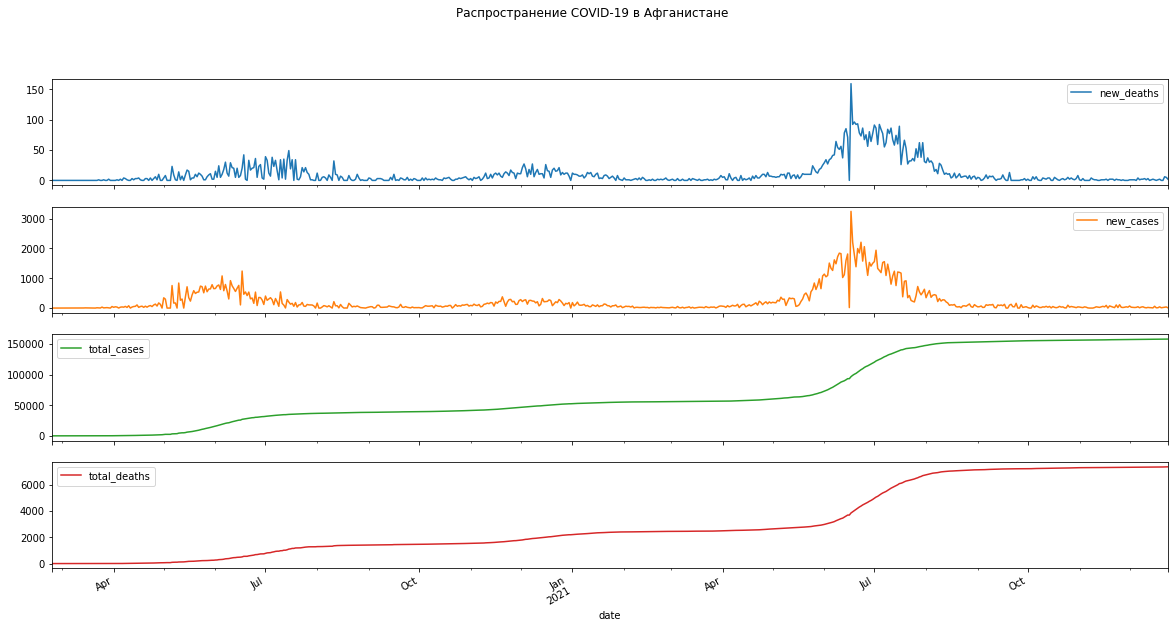

In [25]:
#построим общий график для метрик
df_new[['new_deaths', 'new_cases', 'total_cases', 'total_deaths']].plot(subplots=True, figsize=(20, 10), title = 'Распространение COVID-19 в Афганистане');

Вывод: из построенных графиков наблюдаем, что в период с мая по июль 2020 года в Афганистане наблюдался пик выявления новых случаев и пик смертей. В декабре 2020 года количество смертей немного было увеличено. Пик распространения и смертей от COVID-19 в Афганистане наступил в период с мая по сентябрь 2021 года.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d5627c090>,
      dtype=object)

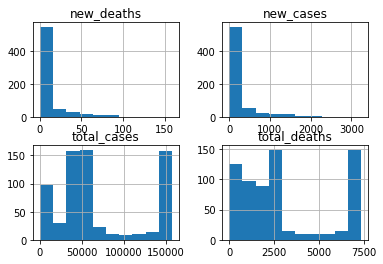

In [26]:
df_new.hist()

Промежуточный вывод:
Анализ показал, что показатель новых заражений связан с показателем новых смертей. 

In [27]:
# построим матрицу корреляции признаков
df_new.corr()

,new_deaths,new_cases,total_cases,total_deaths
new_deaths,1.000000,0.866560,0.199756,0.149716
new_cases,0.866560,1.000000,0.102018,0.052590
total_cases,0.199756,0.102018,1.000000,0.996852
total_deaths,0.149716,0.052590,0.996852,1.000000


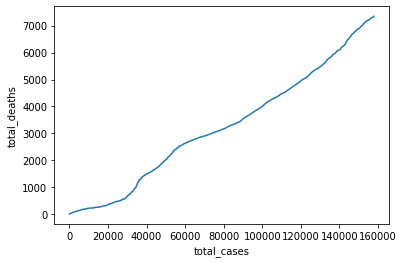

In [28]:
# построим график зависимости total_cases от total_deaths
sns.lineplot(data = df_new, x = 'total_cases', y = 'total_deaths')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



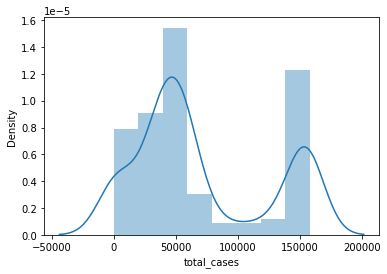

In [29]:
sns.distplot(df_new.total_cases)
#график плотности распределения total_cases

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



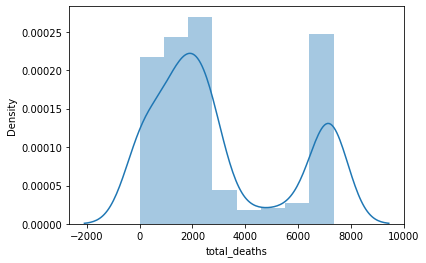

In [30]:
# график плотности распределения total_deaths
sns.distplot(df_new.total_deaths)

Если общее количество смертельных случаев выходит на плато, связано ли это со снижением новых случаев заражения?

Для этого построим прогнозную модель расчёта новых случаев заражения.

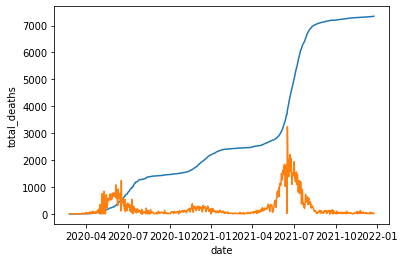

In [31]:
sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
sns.lineplot(data = df_new, x = 'date', y = 'new_cases')

Промежуточный вывод: Увеличение  количества заболевших ведет к увеличению количества смертей.

## Построение моделей, анализ результатов.

Разделение датасета на тренировочную и тестовую (валидационную) выборки, проверка на статичность, построение графиков автокорреляции и частичной автокорреляции, разбивка на сезонность и тренд.

In [32]:
# выделяем выборки, где тестовая размера 10 дней
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

In [33]:
#посмотрим на обучающую выборку
train.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2020-02-24,Afghanistan,2020-02-24,0.0,5.0,5.0,0.0
2020-02-25,Afghanistan,2020-02-25,0.0,0.0,5.0,0.0
2020-02-26,Afghanistan,2020-02-26,0.0,0.0,5.0,0.0
2020-02-27,Afghanistan,2020-02-27,0.0,0.0,5.0,0.0
2020-02-28,Afghanistan,2020-02-28,0.0,0.0,5.0,0.0


In [34]:
#посмотрим на тестовую выборку
test.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2021-12-15,Afghanistan,2021-12-15,2.0,5.0,157665.0,7331.0
2021-12-16,Afghanistan,2021-12-16,1.0,60.0,157725.0,7332.0
2021-12-17,Afghanistan,2021-12-17,0.0,9.0,157734.0,7332.0
2021-12-18,Afghanistan,2021-12-18,1.0,11.0,157745.0,7333.0
2021-12-19,Afghanistan,2021-12-19,2.0,42.0,157787.0,7335.0


In [35]:
r = seasonal_decompose(df_new['new_cases'],model='additive')

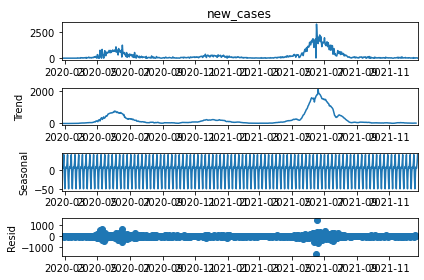

In [36]:
r.plot();

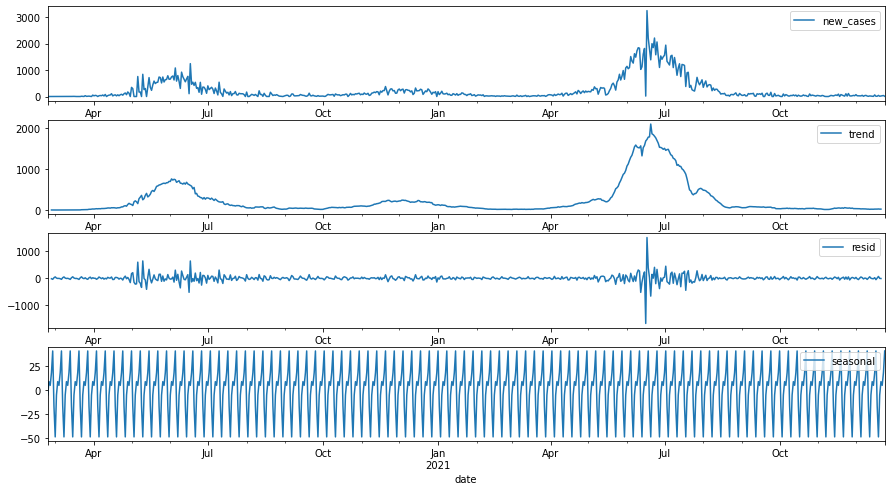

In [37]:
# seasonal_decompose в увеличенном виде
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
r.observed.plot(ax=ax1, legend=True)
r.trend.plot(ax=ax2, legend=True)
r.resid.plot(ax=ax3, legend=True)
r.seasonal.plot(ax=ax4, legend=True)

Построение моделей
Задачи:

описать модель
подобрать оптимальные параметры
создать модель
обучить модель
сделать прогноз на период тестовой выборки
сравнить прогноз с тестовой выборкой (построить график)
оценить качество прогноза
сделать прогноз на 10-15 дней на будущее
сделать выводы о работе данного метода прогнозирования

1й метод прогнозирования - SARIMAX

Сезонное авторегрессионное интегрированное скользящее среднее, SARIMA или Seasonal ARIMA, является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом.

In [90]:
# Запустим pmdarima.auto_arima чтобы получить набор параметров для нашей модели
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary() #включаем сезонность и указываем период сезонности = 1 неделя

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  670
Model:             SARIMAX(2, 1, 5)x(2, 0, [1, 2], 7)   Log Likelihood               -4305.290
Date:                                Sat, 25 Dec 2021   AIC                           8634.579
Time:                                        11:48:51   BIC                           8688.649
Sample:                                             0   HQIC                          8655.524
                                                - 670                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7082      0.048    -35.313      0.000      -1.803      -1.613
ar.L2         -0.8199      0.043    -19.150      0.000      -0.904      -0.736
ma.L1          0.8059      0.053     15.282      0.000       0.703       0.909
ma.L2         -0.5797      0.041    -14.178      0.000      -0.660      -0.500
ma.L3         -0.4222      0.050     -8.382      0.000      -0.521      -0.323
ma.L4          0.3522      0.032     10.925      0.000       0.289       0.415
ma.L5          0.0624      0.033      1.864      0.062      -0.003       0.128
ar.S.L7       -0.1107      0.079     -1.396      0.163      -0.266       0.045
ar.S.L14       0.6505      0.106      6.148      0.000       0.443       0.858
ma.S.L7        0.2625      0.098      2.669      0.008       0.070       0.455
ma.S.L14      -0.3651      0.120     -3.031      0.002      -0.601      -0.129
sigma2      2.581e+04    618.892     41.696      0.000    2.46e+04     2.7e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             44780.94
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.77   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['new_cases'],order=(2, 1, 5), seasonal_order=(2, 0, [1, 2], 7))

#обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

#получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              new_cases   No. Observations:                  660
Model:             SARIMAX(2, 1, 5)x(2, 0, [1, 2], 7)   Log Likelihood               -4246.015
Date:                                Sat, 25 Dec 2021   AIC                           8516.031
Time:                                        11:49:06   BIC                           8569.920
Sample:                                    02-24-2020   HQIC                          8536.920
                                         - 12-14-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7116      0.049    -34.855      0.000      -1.808      -1.615
ar.L2         -0.8222      0.043    -18.992      0.000      -0.907      -0.737
ma.L1          0.8026      0.054     15.001      0.000       0.698       0.907
ma.L2         -0.5854      0.041    -14.201      0.000      -0.666      -0.505
ma.L3         -0.4204      0.051     -8.218      0.000      -0.521      -0.320
ma.L4          0.3561      0.033     10.910      0.000       0.292       0.420
ma.L5          0.0636      0.034      1.863      0.062      -0.003       0.130
ar.S.L7       -0.0938      0.083     -1.129      0.259      -0.257       0.069
ar.S.L14       0.6682      0.110      6.095      0.000       0.453       0.883
ma.S.L7        0.2441      0.102      2.385      0.017       0.043       0.445
ma.S.L14      -0.3915      0.124     -3.152      0.002      -0.635      -0.148
sigma2      2.629e+04    642.823     40.899      0.000     2.5e+04    2.76e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             41816.60
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                             1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(2, 1, 5), seasonal_order=(2, 0, [1, 2], 7)	')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



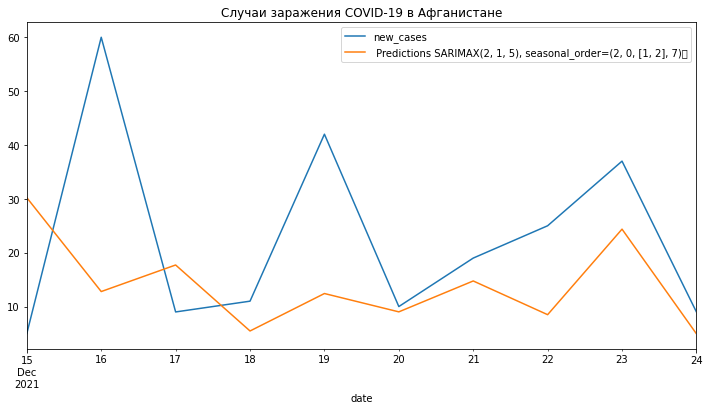

In [95]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19 в Афганистане')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [96]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error = rmse(test['new_cases'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100

print(' MAE Error: {mae_error:11.10}')
print(' MSE Error: {mse_error:11.10}')
print(' RMSE Error: {rmse_error:11.10}')
print(' MAPE Error: {mape_error:11.10}')

 MAE Error: {mae_error:11.10}
 MSE Error: {mse_error:11.10}
 RMSE Error: {rmse_error:11.10}
 MAPE Error: {mape_error:11.10}


In [97]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(0, 1, 2), seasonal_order=(2, 0, 0, 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  670
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 7)   Log Likelihood               -4331.049
Date:                            Sat, 25 Dec 2021   AIC                           8672.099
Time:                                    11:50:39   BIC                           8694.628
Sample:                                02-24-2020   HQIC                          8680.826
                                     - 12-24-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9923      0.012    -83.905      0.000      -1.015      -0.969
ma.L2          0.2939      0.012     25.023      0.000       0.271       0.317
ar.S.L7        0.1052      0.017      6.252      0.000       0.072       0.138
ar.S.L14       0.2535      0.023     10.933      0.000       0.208       0.299
sigma2      2.451e+04    393.818     62.237      0.000    2.37e+04    2.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):             32364.39
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               3.16   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

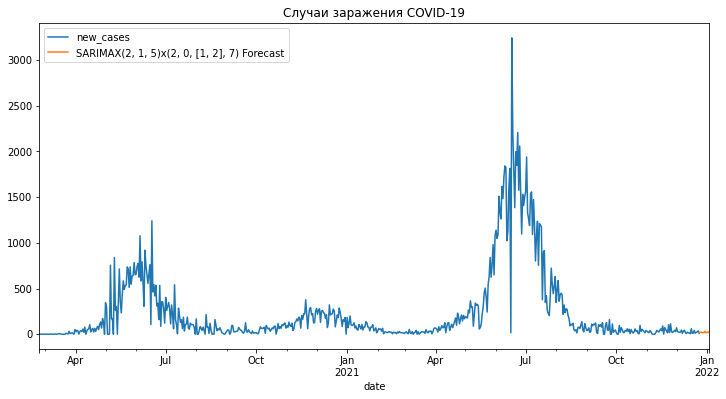

In [98]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(2, 1, 5)x(2, 0, [1, 2], 7) Forecast')

#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

Вывод: Модель SARIMAX показала нам, что количество заболевших в Афганистане в течение 10 дней останется на прежнем уровне.

2й метод прогнозирования - PROPHET

Prophet — это библиотека с открытым исходным кодом от компании Facebook. Она предназначена для прогнозирования временных рядов. 

In [73]:
# подготовим данные для модели
train_prophet = train[['date','new_cases']]
test_prophet = test[['date','new_cases']]

In [74]:
# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [75]:
# подготовим данные по всему датасету для модели
df_new_prophet = df_new[['date','new_cases']]
df_new_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [76]:
# создаем модель с подобранными параметрами
# multiplicative - https://towardsdatascience.com/using-prophet-after-covid-read-this-first-fc27cd77f3d7

model_prophet = Prophet(seasonality_mode='multiplicative') #создаем объект модели профет, не устанавливая параметры (из дз помним, что модель сам-но подбирает параметры)

#обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
# делаем прогноз на 10 дней
future_prophet = model_prophet.make_future_dataframe(periods=10)

In [78]:
##предсказываем значения по модели
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-02-24,59.110028,-308.817361,427.879760,59.110028,59.110028,-0.003794,-0.003794,-0.003794,-0.003794,-0.003794,-0.003794,0.0,0.0,0.0,58.885752
1,2020-02-25,60.893798,-288.964667,435.468618,60.893798,60.893798,0.069428,0.069428,0.069428,0.069428,0.069428,0.069428,0.0,0.0,0.0,65.121560
2,2020-02-26,62.677569,-306.257602,410.522756,62.677569,62.677569,-0.056877,-0.056877,-0.056877,-0.056877,-0.056877,-0.056877,0.0,0.0,0.0,59.112644
3,2020-02-27,64.461340,-295.446279,427.359794,64.461340,64.461340,0.132551,0.132551,0.132551,0.132551,0.132551,0.132551,0.0,0.0,0.0,73.005728
4,2020-02-28,66.245111,-267.560395,446.895126,66.245111,66.245111,0.210909,0.210909,0.210909,0.210909,0.210909,0.210909,0.0,0.0,0.0,80.216810


In [79]:
#устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-24,2020-02-24,59.110028,-308.817361,427.879760,59.110028,59.110028,-0.003794,-0.003794,-0.003794,-0.003794,-0.003794,-0.003794,0.0,0.0,0.0,58.885752
2020-02-25,2020-02-25,60.893798,-288.964667,435.468618,60.893798,60.893798,0.069428,0.069428,0.069428,0.069428,0.069428,0.069428,0.0,0.0,0.0,65.121560
2020-02-26,2020-02-26,62.677569,-306.257602,410.522756,62.677569,62.677569,-0.056877,-0.056877,-0.056877,-0.056877,-0.056877,-0.056877,0.0,0.0,0.0,59.112644
2020-02-27,2020-02-27,64.461340,-295.446279,427.359794,64.461340,64.461340,0.132551,0.132551,0.132551,0.132551,0.132551,0.132551,0.0,0.0,0.0,73.005728
2020-02-28,2020-02-28,66.245111,-267.560395,446.895126,66.245111,66.245111,0.210909,0.210909,0.210909,0.210909,0.210909,0.210909,0.0,0.0,0.0,80.216810


In [80]:
prediction_prophet[['ds', 'yhat']] # оставим только нужные

,ds,yhat
ds,,
2020-02-24,2020-02-24,58.885752
2020-02-25,2020-02-25,65.121560
2020-02-26,2020-02-26,59.112644
2020-02-27,2020-02-27,73.005728
2020-02-28,2020-02-28,80.216810
...,...,...
2021-12-20,2021-12-20,-299.290544
2021-12-21,2021-12-21,-328.306030
2021-12-22,2021-12-22,-295.719598


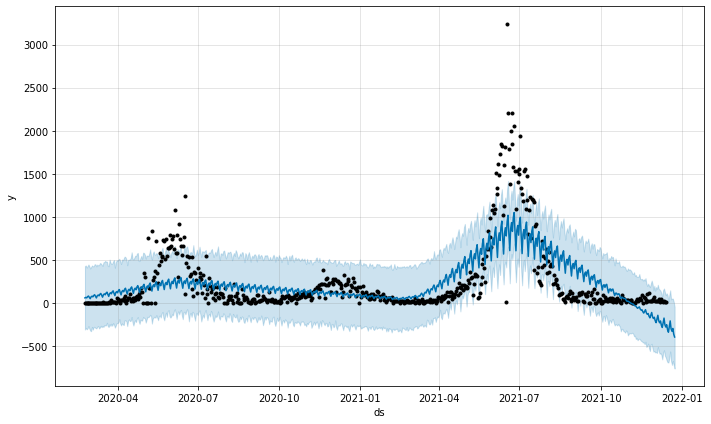

In [81]:
#сравниваем прогноз и тестовую выборку, где черные точки - выборка
model_prophet.plot(prediction_prophet);

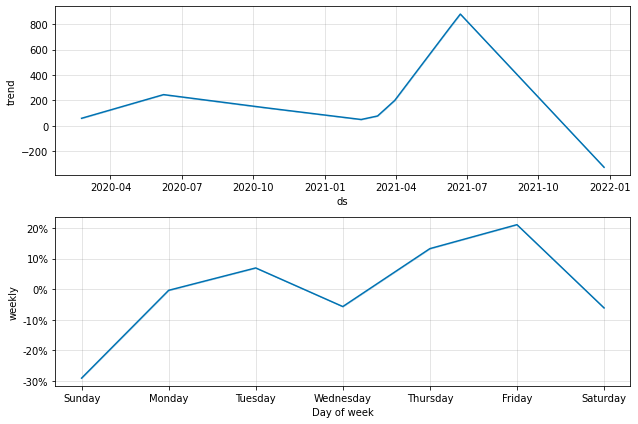

In [82]:
# разложим ряд на основные компоненты — тренд и сезонность
model_prophet.plot_components(prediction_prophet);

In [83]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 328.9397086
Prophet MSE Error: 110925.8294
Prophet RMSE Error: 333.0552948
Prophet MAPE Error:  2456.96533


In [84]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_new_prophet)

# говорим профету сделать дата-фрейм на 10 дней вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


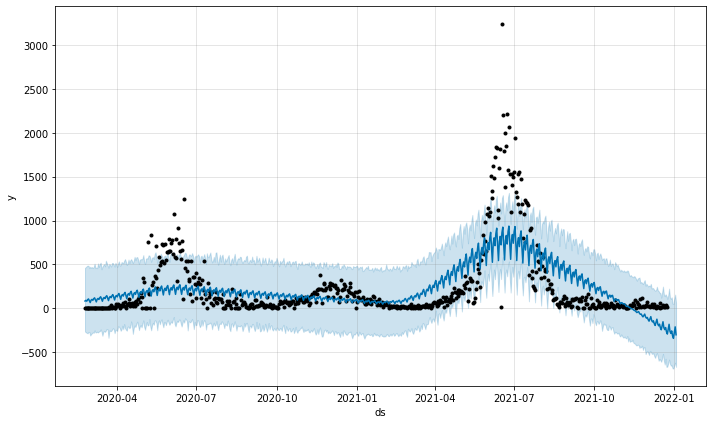

In [85]:
#сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet);

In [86]:
#устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [87]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-24,2020-02-24,82.445838,-264.459367,461.554694,82.445838,82.445838,-0.000633,-0.000633,-0.000633,-0.000633,-0.000633,-0.000633,0.0,0.0,0.0,82.393684
2020-02-25,2020-02-25,83.917032,-274.218867,468.743609,83.917032,83.917032,0.072945,0.072945,0.072945,0.072945,0.072945,0.072945,0.0,0.0,0.0,90.038347
2020-02-26,2020-02-26,85.388227,-279.463056,479.540627,85.388227,85.388227,-0.055927,-0.055927,-0.055927,-0.055927,-0.055927,-0.055927,0.0,0.0,0.0,80.612698
2020-02-27,2020-02-27,86.859421,-285.528323,486.063490,86.859421,86.859421,0.123635,0.123635,0.123635,0.123635,0.123635,0.123635,0.0,0.0,0.0,97.598259
2020-02-28,2020-02-28,88.330615,-269.680109,483.686958,88.330615,88.330615,0.203791,0.203791,0.203791,0.203791,0.203791,0.203791,0.0,0.0,0.0,106.331604


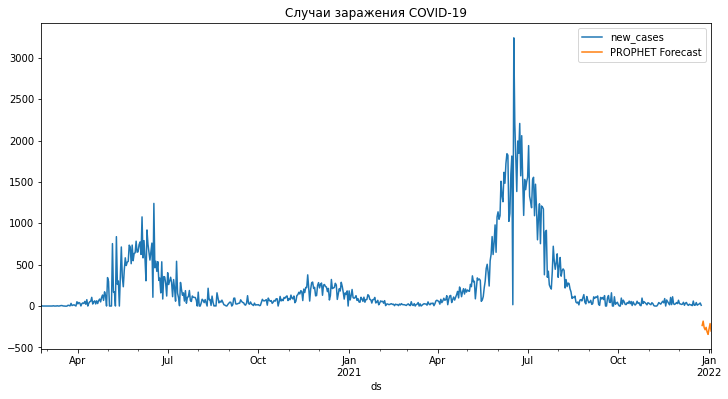

In [88]:
#строим график на будущее
ax = df_new_prophet['y'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["new_cases", "PROPHET Forecast"]);

Вывод: Получился довольно интересный прогноз, почему-то не соединяющийся с основными данными. Прогноз показывает, что в течение 10 дней будет наблюдаться спад заболевания, затем произойдет незначительный скачек.

3й метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)

Экспоненциальное сглаживание — метод математического преобразования, используемый при прогнозировании временных рядов.

Метод также известен как метод простого экспоненциального сглаживания, или метод Брауна

In [58]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [59]:
#посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 2.0,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': -0.2727272727272729,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.16999999999999998,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.16999999999999998,
 'use_boxcox': False}

In [60]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [61]:
test.index[0]

Timestamp('2021-12-15 00:00:00')

In [62]:
test.index[-1]

Timestamp('2021-12-24 00:00:00')

In [63]:
prediction_exps

array([11.37815501,  9.04308088,  6.70800675,  4.37293261,  2.03785848,
       -0.29721566, -2.63228979, -4.96736393, -7.30243806, -9.63751219])

In [64]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-12-10 00:00:00", periods=10, freq="D")

prediction_exps.columns = ['prediction_exps']

In [65]:
#проверим
prediction_exps.head()

,prediction_exps
2021-12-10,11.378155
2021-12-11,9.043081
2021-12-12,6.708007
2021-12-13,4.372933
2021-12-14,2.037858


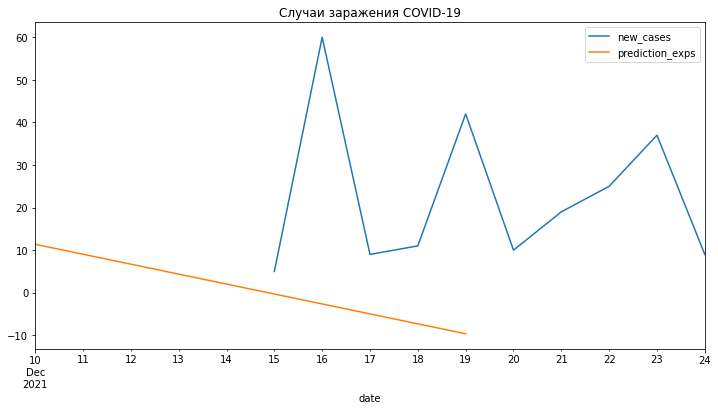

In [66]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [69]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['new_cases'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['new_cases'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['new_cases'])/test['new_cases'])*100

print ('MAE Error: {mae_error:11.10}')
print ('MSE Error: {mse_error:11.10}')
print ('RMSE Error: {rmse_error:11.10}')
print ('MAPE Error: {mape_error:11.10}')

MAE Error: {mae_error:11.10}
MSE Error: {mse_error:11.10}
RMSE Error: {rmse_error:11.10}
MAPE Error: {mape_error:11.10}


In [70]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df_new['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность
fut_model_exps.fit()

#задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df_new)-1, end=len(df_new)+9)

#преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-12-19", periods=11, freq="D")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



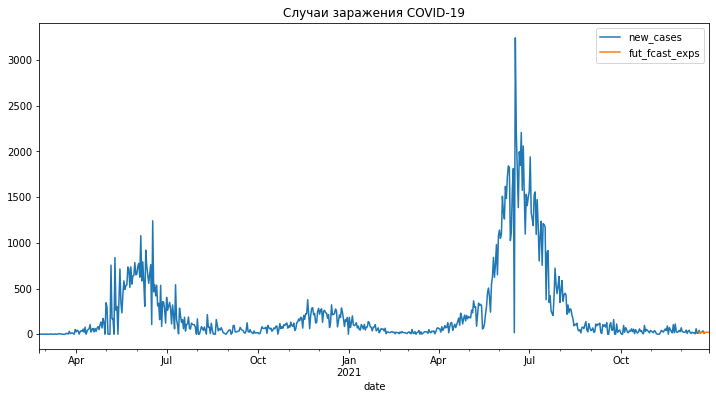

In [71]:
#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

Промежуточный вывод: Такое ощущение, что "Экспоненциальное сглаживание" показало нам прогноз, что количество новых заболевших останется на прежнем уровне.

## Выводы

В Итоговой работе мы использовали три модели прогнозирования (SARIMA, PROPHET и "Экспоненциальное сглаживание"). Для прогнозирования брали временной отрезок равный 10 дням. Модели SARIMA и "Экспоненциальное сглаживание" показали одинаковый результат, согласно которому количество новых заболевших в Афганистане не увеличится. Модель PROPHET указала что количество заболевших резко пойдет на спад. 
Мой результат такой: Если две модели дают одинаковый результат, будем считать, что количество заболевших в Афганистане, в течение 10 дней не увелится.